# Updates

In [1]:
import sys
sys.path.append('/Users/spindicate/Documents/programming/zooscraper/')

import django
django.setup()

In [2]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [5]:
from datetime import datetime as dt, timedelta
import pandas as pd

In [6]:
from casestudy.see19.see19 import CaseStudy, get_baseframe
from see19.constants import COUNT_TYPES

In [7]:
from casestudy.update.helpers import ExceptionLogger
from casestudy.tweetbot import TweetBot

In [8]:
baseframe = get_baseframe()

In [9]:
LOG_PATH = '/Users/spindicate/Documents/programming/zooscraper/casestudy/tweetbot/tweet_logs/'
filename = 'twitter-{}.log'.format(dt.now().strftime('%Y-%m-%d'))
logfile = LOG_PATH + filename
exc_logger = ExceptionLogger(logfile)

In [24]:
tweetbot = TweetBot(test=False, wait=False)
# tweetbot = TweetBot()

In [11]:
countries = [
    'United States of America (the)',
    'Brazil', 
    'Australia', 
    'Japan', 'Singapore', 'Taiwan',  'Korea (the Republic of)',
    'Hong Kong', 
    'Malaysia',
    'Canada', 'Italy',
    'Germany', 
    'Sweden',
    'United Kingdom of Great Britain and Northern Ireland (the)',
    'France', 
    'Norway',  
    'Spain', 
    'Denmark', 'Finland',
]

factors_with_dmas = ['strindex']
factor_dmas = {factor: 28 for factor in factors_with_dmas}
mobi_dmas = {factor: 1 for factor in [*CaseStudy.GMOBIS, *CaseStudy.AMOBIS]}
factors = factors_with_dmas + CaseStudy.GMOBIS + ['A65PLUSB'] + CaseStudy.AMOBIS

casestudy = CaseStudy(
    baseframe, countries=countries, count_dma=3, factors=factors, 
    factor_dmas=factor_dmas, mobi_dmas=mobi_dmas, start_hurdle=dt(2020,3,1), start_factor='date', lognat=True,
    min_deaths=1,
)

## Custom Comparison Chart

In [15]:
region_groups = [
    ['Texas', 'Alabama', 'Arizona'],
    ['Georgia', 'Tennessee', 'Florida'],
    ['British Columbia', 'Ontario', 'New South Wales'],
    ['Illinois', 'Ohio', 'Massachusetts'], 
    ['California', 'Florida', 'Washington'],
    ['Sweden', 'Norway', 'Finland', 'Denmark'],
    ['Spain', 'Germany', 'France'],
    ['Lombardia', 'New York', 'New Jersey'],
    ['Sao Paulo', 'Rio De Janeiro'],
    ['Hong Kong', 'Singapore'],
    ['Japan', 'Malaysia', 'Korea, South']
    
]
for regions in region_groups:
    for count_type in ['cases', 'deaths']:
        wrapped_chart = exc_logger.wrap()(tweetbot.count_comparison)
        wrapped_chart(casestudy, count_type, regions)

    wrapped_chart = exc_logger.wrap()(tweetbot.amobi_comparison)
    wrapped_chart(casestudy, regions)

    status = """
        Change in Apple Mobility Index (driving) along with New Case and Fatality updates for {}
    """.format(' & '.join(regions))

    wrapped_tweet = exc_logger.wrap()(tweetbot.new_tweet)
    wrapped_tweet(status)

TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


FileNotFoundError(2, 'No such file or directory')


TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


TweepError('Unable to access file: No such file or directory')


## Wave Analysis

In [16]:
df_ex = casestudy.df[casestudy.df.country_code != 'BRA']
df_braz = casestudy.df[casestudy.df.country_code == 'BRA']
dfs = {'ex_BRA': df_ex, 'BRA': df_braz}


        Wave Update for New Cases. Out of 104 regions in USA, CAD, AUS, Europe and Asia, 45 regions are experiencing a weak wave, 29 are experiencing a sustained wave, and 4 are peaking. 
        
TweepError('Unable to access file: No such file or directory')


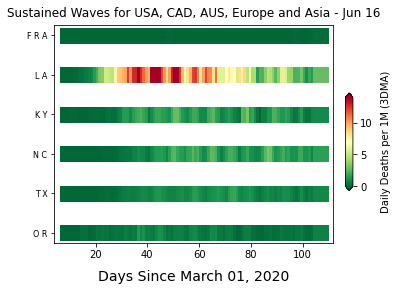


        Wave Update for New Deaths. Out of 104 regions in USA, CAD, AUS, Europe and Asia, 21 regions are experiencing a weak wave, 6 are experiencing a sustained wave, and 1 is peaking. 
        
TweepError('Unable to access file: No such file or directory')


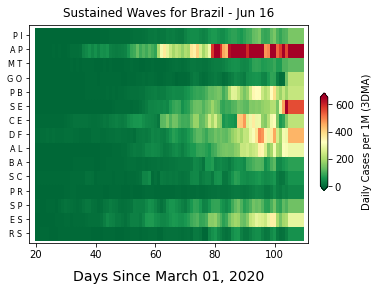

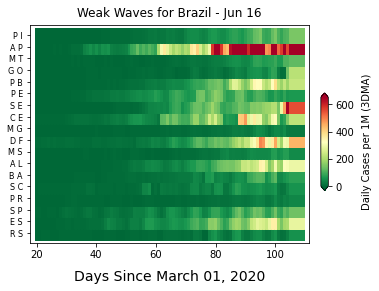


        Wave Update for New Cases. Out of 27 regions in Brazil, 18 regions are experiencing a weak wave, 15 are experiencing a sustained wave, and 2 are peaking. 
        
TweepError('Unable to access file: No such file or directory')


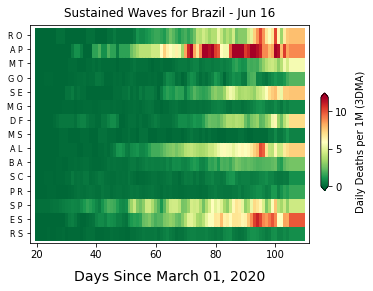

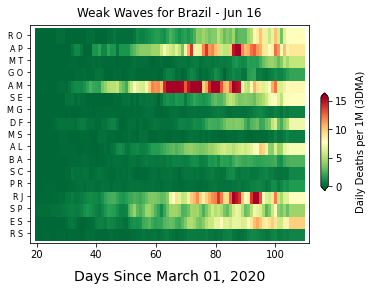


        Wave Update for New Deaths. Out of 27 regions in Brazil, 17 regions are experiencing a weak wave, 15 are experiencing a sustained wave, and 4 are peaking. 
        
TweepError('Unable to access file: No such file or directory')


In [18]:
for key, df in dfs.items():
    for count_type in ['cases', 'deaths']:
        comp_category = count_type + '_new_dma_per_1M'
        wrappedfinder = exc_logger.wrap()(tweetbot.wavefinder)
        wave_types, regions_str, end_date = wrappedfinder(df, comp_category, key)
        
        for wave_type, regions in wave_types.items():
            title = ' '.join(wave_type.split('_')).title() + 's' + ' for {} - {}'.format(regions_str, end_date.strftime('%b %d'))

            if len(regions) == 0:
                pass
            if len(regions) <= 4 and len(regions) > 0:
                wrapped_chart = exc_logger.wrap()(tweetbot.multiline_comparison)
                wrapped_chart(casestudy, comp_category, regions, title)

            elif len(regions) > 4 and len(regions) <= 20:
                wrapped_chart = exc_logger.wrap()(tweetbot.scatterflow)
                wrapped_chart(casestudy, comp_category, regions, title)

        num_regions = df.region_name.unique().shape[0]
        status = """
        Wave Update for New {}. Out of {} regions in {}, {} regions are experiencing a weak wave, {} are experiencing a sustained wave, and {} peaking. 
        """.format(
            count_type.capitalize(), num_regions, regions_str,
            len(wave_types['weak_wave']), 
            len(wave_types['sustained_wave']), 
                   str(len(wave_types['peak_wave'])) + ' is' if len(wave_types['peak_wave']) == 1 else str(len(wave_types['peak_wave'])) + ' are'
        )
        print (status)
        wrapped_tweet = exc_logger.wrap()(tweetbot.new_tweet)
        wrapped_tweet(status)

# Testing Updates

In [19]:
casestudy = CaseStudy(
    baseframe, countries='United States of America (the)',
    start_hurdle=dt(2020,4,26), start_factor='date', count_dma=7,
    min_deaths=1,
)

TweepError('Unable to access file: No such file or directory')


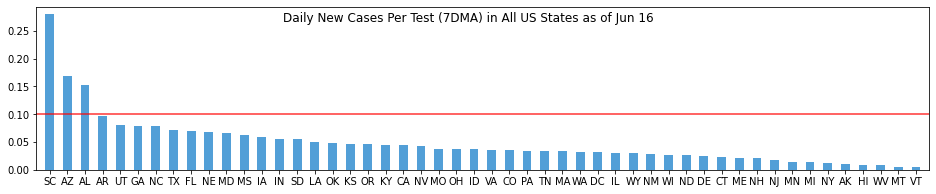

In [20]:
wrapped_chart = exc_logger.wrap()(tweetbot.positivity_bar)
wrapped_chart(casestudy)

status = """Testing efficiency is strong in the US, with vast majority of states below the key 10% positivity threshold
#COVID19 #COVID #Covid19usa #coronavirus #c19
"""
wrapped_tweet = exc_logger.wrap()(tweetbot.new_tweet)
wrapped_tweet(status)

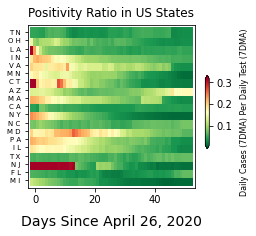

TweepError('Unable to access file: No such file or directory')


In [21]:
wrapped_chart = exc_logger.wrap()(tweetbot.positivity_race)
wrapped_chart(casestudy)

status = """Positivity ratio in the most impacted US states in the past month  #covid19 #covid #c19 #coronavirus
    """
wrapped_tweet = exc_logger.wrap()(tweetbot.new_tweet)
wrapped_tweet(status, wait_time=0)

In [22]:
factors_with_dmas = CaseStudy.STRINDEX_CATS
factor_dmas = {factor: 5 for factor in factors_with_dmas}
factors = factors_with_dmas + ['A65PLUSB']
countries = [
    'United States of America (the)', 'Japan', 'Korea (the Republic of)', 
    'Hong Kong', 'Australia', 'Taiwan (Province of China)',
    'Canada', 'Mexico', 'Brazil', 'Spain', 'Germany', 'Italy', 'France',
    'Malaysia', 'Singapore', 'Denmark', 'Sweden', 'Finland', 
]
excluded_regions = ['Saint Pierre and Miquelon', 'Saint Barthelemy', 'Reunion', 'New Caledonia', 'Greenland',
    'French Polynesia', 'French Guiana', 'Faroe Islands',
]
casestudy = CaseStudy(
    baseframe, countries=countries, excluded_regions=excluded_regions, count_dma=3, factors=factors, 
    factor_dmas=factor_dmas, start_hurdle=dt(2020,1,15), start_factor='date', lognat=True,
    min_deaths=1, country_level=True,
)

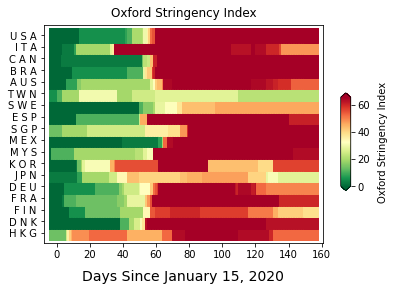

Waiting 0 mins


In [25]:
wrapped_chart = exc_logger.wrap()(tweetbot.strindex_race)
wrapped_chart(casestudy)

status = """Lighter shading towards the right of the graph shows the relaxing of quarantine in some countries #covid19 #covid #c19 #coronavirus
"""
wrapped_tweet = exc_logger.wrap()(tweetbot.new_tweet)
wrapped_tweet(status, wait_time=0)